# Modeling KMeans, KAgglomerativeClustering, Annoy

## Imports

In [5]:
pip install --user annoy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import pickle as pkl
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from annoy import AnnoyIndex
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans # import from sklearn
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

## Pickle Load and Helper Functions

In [7]:
df_for_brands = pkl.load(open('df_pickles/df_reg_1.p','rb'))

In [8]:
df_for_brands.drop('price',1,inplace=True)

In [9]:
df_for_brands_gas = df_for_brands[df_for_brands['Engine type']!='Electric']

In [10]:
df_for_brands_elec = df_for_brands[df_for_brands['Engine type']=='Electric']

In [11]:
prices = pkl.load(open('df_pickles/prices.p','rb'))

In [12]:
df_for_brands_gas = pd.concat([df_for_brands_gas, prices],1)

In [13]:
## GAS ##

In [14]:
df_gas = pkl.load(open('df_pickles/df_gas_sc_dmd.p','rb'))

In [15]:
df_gas_mod = df_gas.drop(['model', 'front_suspension_type_1',
       'front_suspension_type_2', 'front_suspension_type_3',
       'front_suspension_type_4', 'front_suspension_type_5',
       'front_suspension_type_6', 'front_suspension_type_7',
       'front_suspension_type_8', 'front_suspension_type_9', 
        'front_suspension_type_10', 'front_suspension_type_11',
       'front_suspension_type_12', 'front_wheel_diameter_15',
       'front_wheel_diameter_16', 'front_wheel_diameter_17',
       'front_wheel_diameter_18', 'front_wheel_diameter_19',
       'front_wheel_diameter_20', 'front_wheel_diameter_21',
       'front_wheel_diameter_22', 'rear_suspension_type_1',
       'rear_suspension_type_2', 'rear_suspension_type_3',
       'rear_suspension_type_4', 'rear_suspension_type_5', 
                          'rear_suspension_type_6',
       'rear_suspension_type_7', 'rear_suspension_type_8',
       'rear_suspension_type_9', 'rear_suspension_type_10',
       'rear_wheel_diameter_15', 'rear_wheel_diameter_16',
       'rear_wheel_diameter_17', 'rear_wheel_diameter_18',
       'rear_wheel_diameter_19', 'rear_wheel_diameter_20',
       'rear_wheel_diameter_21', 'rear_wheel_diameter_22',
                         'brand_1',
       'brand_2', 'brand_3', 'brand_4', 'brand_5', 'brand_6', 'brand_7',
       'brand_8', 'brand_9', 'brand_10', 'brand_11', 'brand_12', 'brand_13',
       'brand_14', 'brand_15', 'brand_16', 'brand_17', 'brand_18', 'brand_19',
       'brand_20', 'brand_21', 'brand_22', 'brand_23', 'brand_24', 'brand_25',
       'brand_26', 'brand_27', 'brand_28', 'brand_29', 'brand_30', 'brand_31',
       'brand_32', 'brand_33', 'brand_34', 'brand_35', 'brand_36', 'brand_37',
       'brand_39', 'brand_40', 'brand_41'], 1)

In [16]:
## ELEC

In [17]:
df_elec = pkl.load(open('df_pickles/df_elec_sc_dmd.p','rb'))

In [18]:
df_elec.columns[20:]

Index(['passenger_doors_487', 'passenger_doors_687', 'passenger_doors_1013',
       'passenger_capacity_4', 'passenger_capacity_5',
       'passenger_capacity_354', 'passenger_capacity_382',
       'passenger_capacity_443', 'passenger_capacity_485',
       'passenger_capacity_486', 'passenger_capacity_487',
       'passenger_capacity_687', 'passenger_capacity_1013', 'engine_type_354',
       'engine_type_382', 'engine_type_443', 'engine_type_485',
       'engine_type_486', 'engine_type_487', 'engine_type_687',
       'engine_type_1013', 'drive_type_2', 'drive_type_3', 'drive_type_354',
       'drive_type_382', 'drive_type_443', 'drive_type_485', 'drive_type_486',
       'drive_type_487', 'drive_type_687', 'drive_type_1013',
       'front_suspension_type_6', 'front_suspension_type_354',
       'front_suspension_type_382', 'front_suspension_type_443',
       'front_suspension_type_485', 'front_suspension_type_486',
       'front_suspension_type_487', 'front_suspension_type_687',
       '

In [19]:
df_elec_mod = df_elec.drop(['model', 'front_suspension_type_6', 'front_suspension_type_354',
       'front_suspension_type_382', 'front_suspension_type_443',
       'front_suspension_type_485', 'front_suspension_type_486',
       'front_suspension_type_487', 'front_suspension_type_687',
       'front_suspension_type_1013', 'front_wheel_diameter_16.0',
       'front_wheel_diameter_17.0', 'front_wheel_diameter_18.0',
       'front_wheel_diameter_19.0', 'front_wheel_diameter_20.0',
       'front_wheel_diameter_354.0', 'front_wheel_diameter_382.0',
       'front_wheel_diameter_443.0', 'front_wheel_diameter_485.0',
       'front_wheel_diameter_486.0', 'front_wheel_diameter_487.0',
       'front_wheel_diameter_687.0', 'front_wheel_diameter_1013.0',
       'rear_suspension_type_6', 'rear_suspension_type_9',
       'rear_suspension_type_354', 'rear_suspension_type_382',
       'rear_suspension_type_443', 'rear_suspension_type_485',
       'rear_suspension_type_486', 'rear_suspension_type_487',
       'rear_suspension_type_687', 'rear_suspension_type_1013',
       'rear_wheel_diameter_16.0', 'rear_wheel_diameter_17.0',
       'rear_wheel_diameter_18.0', 'rear_wheel_diameter_19.0',
       'rear_wheel_diameter_20.0', 'rear_wheel_diameter_354.0',
       'rear_wheel_diameter_382.0', 'rear_wheel_diameter_443.0',
       'rear_wheel_diameter_485.0', 'rear_wheel_diameter_486.0',
       'rear_wheel_diameter_487.0', 'rear_wheel_diameter_687.0',
       'rear_wheel_diameter_1013.0', 'brand_11', 'brand_16', 'brand_17',
       'brand_19', 'brand_21', 'brand_33', 'brand_38', 'brand_39', 'brand_40',
       'brand_42', 'brand_354', 'brand_382', 'brand_443', 'brand_485',
       'brand_486', 'brand_487', 'brand_687', 'brand_1013'], 1)

In [20]:
def threed_figures(model, df):
    fignum = 1
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = model.labels_

    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'].astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title(str(model))
    ax.dist = 12

    # Plot the ground truth
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#     for name, label in [('PCA1', 0), ('PCA2', 1), ('PCA3', 2)]:
#         ax.text3D(df[y == label, 3].mean(),
#                   df[y == label, 0].mean(),
#                   df[y == label, 2].mean() + 2, name,
#                   horizontalalignment='center',
#                   bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
    #Reorder the labels to have colors matching the cluster results
#    y = np.choose(df['labels'], [1, 2, 0]).astype(np.float)
    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'], edgecolor='k',cmap='hsv',s=16)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('Car Cluster Representation After Reducing Dimension to 3D')
    ax.dist = 12

    fig.show();

In [21]:
pca = PCA(n_components=3)

## KMeans

In [19]:
k_means = KMeans(n_clusters=30, n_init=20, max_iter=1500)
k_means.fit(df_gas_mod)
cluster_assignments = k_means.predict(df_gas_mod)

In [20]:
labels = k_means.labels_

In [21]:
df_gas_mod_kmeans = df_gas_mod.copy()

In [22]:
df_gas_mod_kmeans['labels'] = cluster_assignments

In [23]:
df_gas_mod_kmeans[0:5];

In [24]:
kmeans_ft_pca = pca.fit_transform((df_gas_mod_kmeans.iloc[:,:-1]))
df_gas_mod_kmeans['x']=kmeans_ft_pca[:,0]
df_gas_mod_kmeans['y']=kmeans_ft_pca[:,1]
df_gas_mod_kmeans['z']=kmeans_ft_pca[:,2]
pca.components_.shape

(3, 35)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


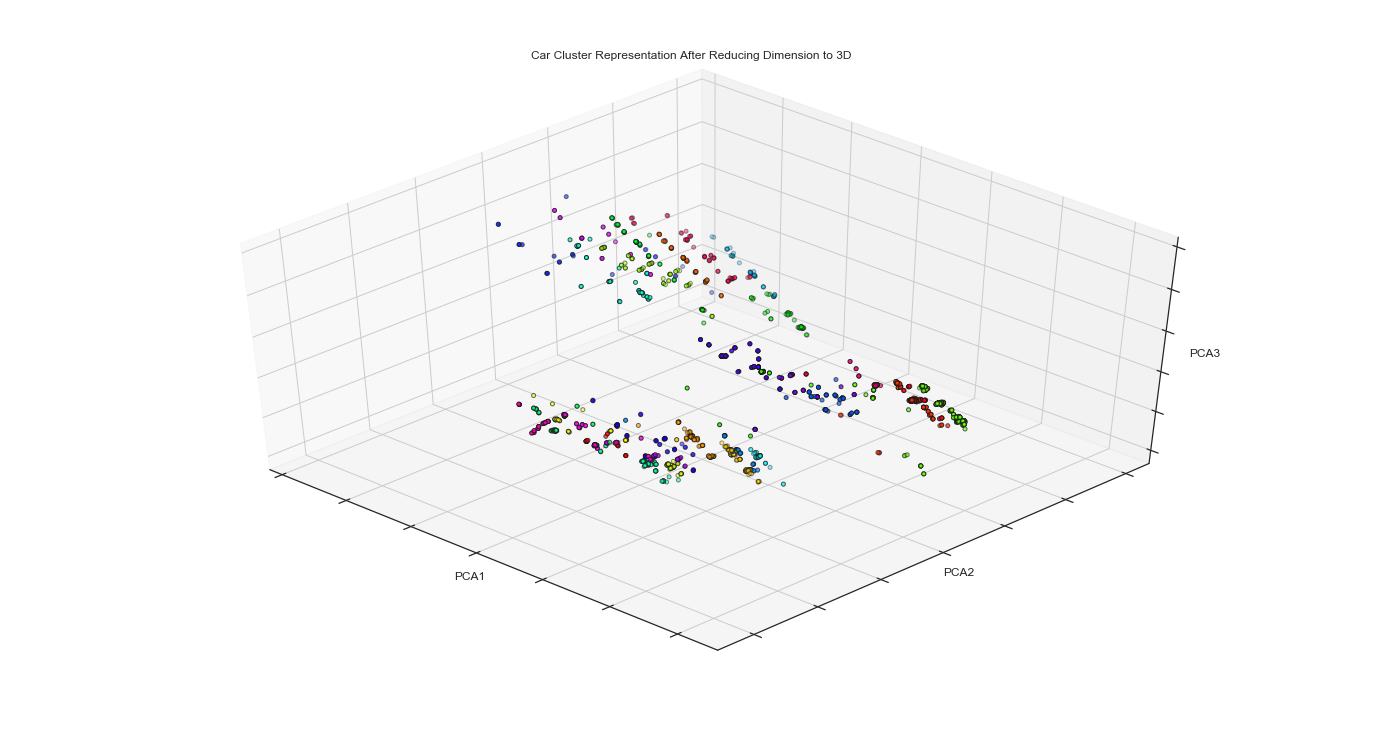

In [25]:
threed_figures(k_means, df_gas_mod_kmeans)

## AgglomerativeClustering

### Linkage = Single

In [26]:
df_gas_hac_single = df_gas_mod.copy()

In [27]:
agg_clust_single = AgglomerativeClustering(linkage='single', n_clusters=30)
assigned_clust_single = agg_clust_single.fit_predict(df_gas_hac_single)
df_gas_hac_single['labels'] = assigned_clust_single

In [28]:
hac_single_ft_pca = pca.fit_transform((df_gas_hac_single.iloc[:,:-1]))
df_gas_hac_single['x']=hac_single_ft_pca[:,0]
df_gas_hac_single['y']=hac_single_ft_pca[:,1]
df_gas_hac_single['z']=hac_single_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


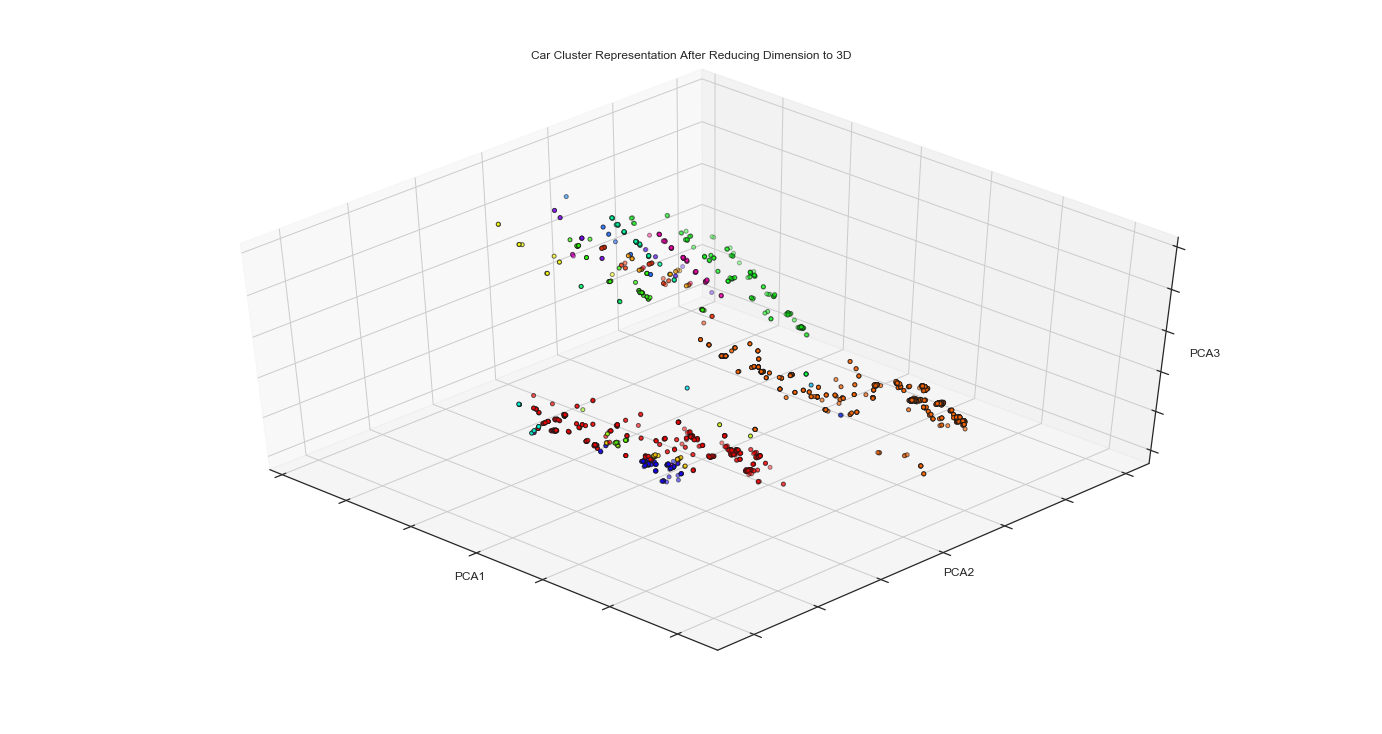

In [29]:
threed_figures(agg_clust_single, df_gas_hac_single)

### Linkage = Complete

In [30]:
df_gas_hac_complete = df_gas_mod.copy()

In [31]:
agg_clust_complete = AgglomerativeClustering(linkage='complete', n_clusters=30)
assigned_clust_complete = agg_clust_complete.fit_predict(df_gas_hac_complete)
df_gas_hac_complete['labels'] = assigned_clust_complete

In [32]:
hac_comp_ft_pca = pca.fit_transform((df_gas_hac_complete.iloc[:,:-1]))
df_gas_hac_complete['x']=hac_comp_ft_pca[:,0]
df_gas_hac_complete['y']=hac_comp_ft_pca[:,1]
df_gas_hac_complete['z']=hac_comp_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


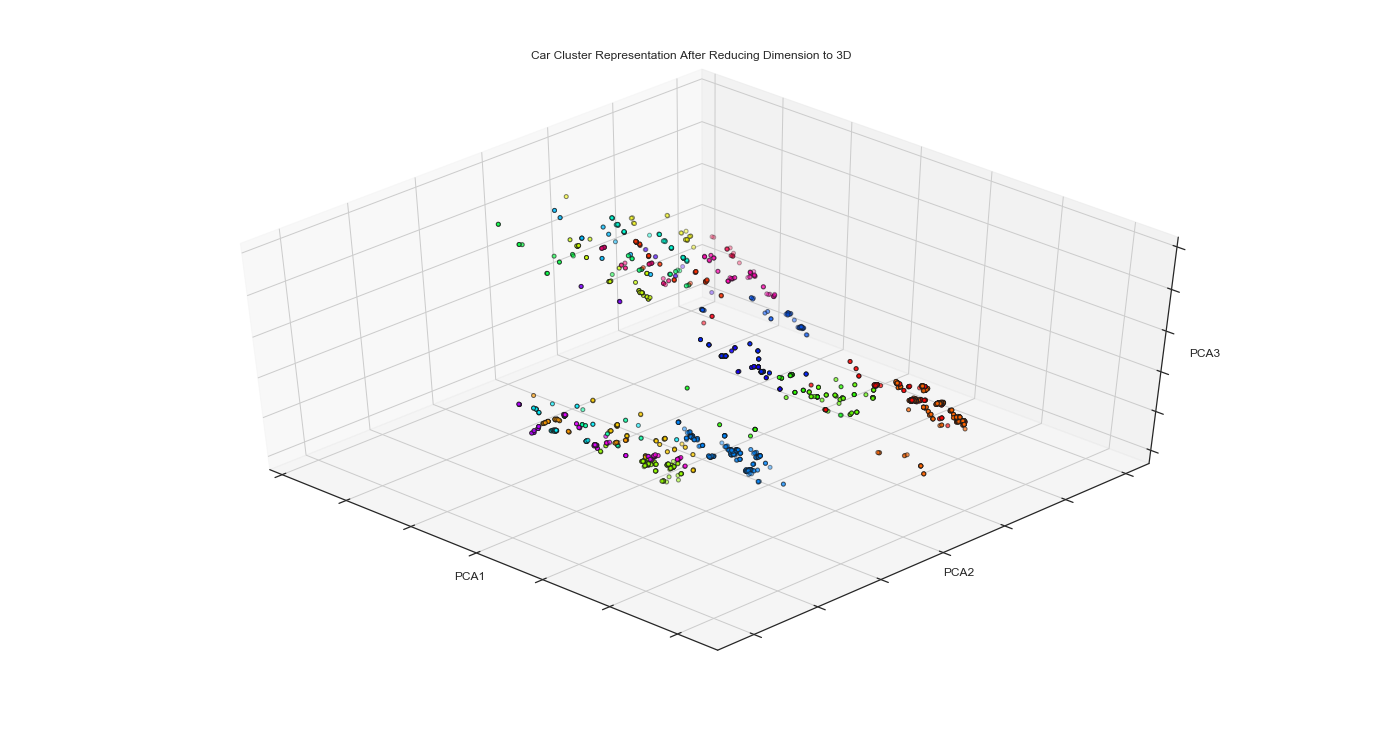

In [33]:
threed_figures(agg_clust_complete, df_gas_hac_complete)

### Linkage = Average

In [34]:
df_gas_hac_avg = df_gas_mod.copy()

In [35]:
agg_clust_avg = AgglomerativeClustering(linkage='average', n_clusters=30)
assigned_clust_avg = agg_clust_avg.fit_predict(df_gas_hac_avg)
df_gas_hac_avg['labels'] = assigned_clust_avg

In [36]:
hac_avg_ft_pca = pca.fit_transform((df_gas_hac_avg.iloc[:,:-1]))
df_gas_hac_avg['x']=hac_avg_ft_pca[:,0]
df_gas_hac_avg['y']=hac_avg_ft_pca[:,1]
df_gas_hac_avg['z']=hac_avg_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


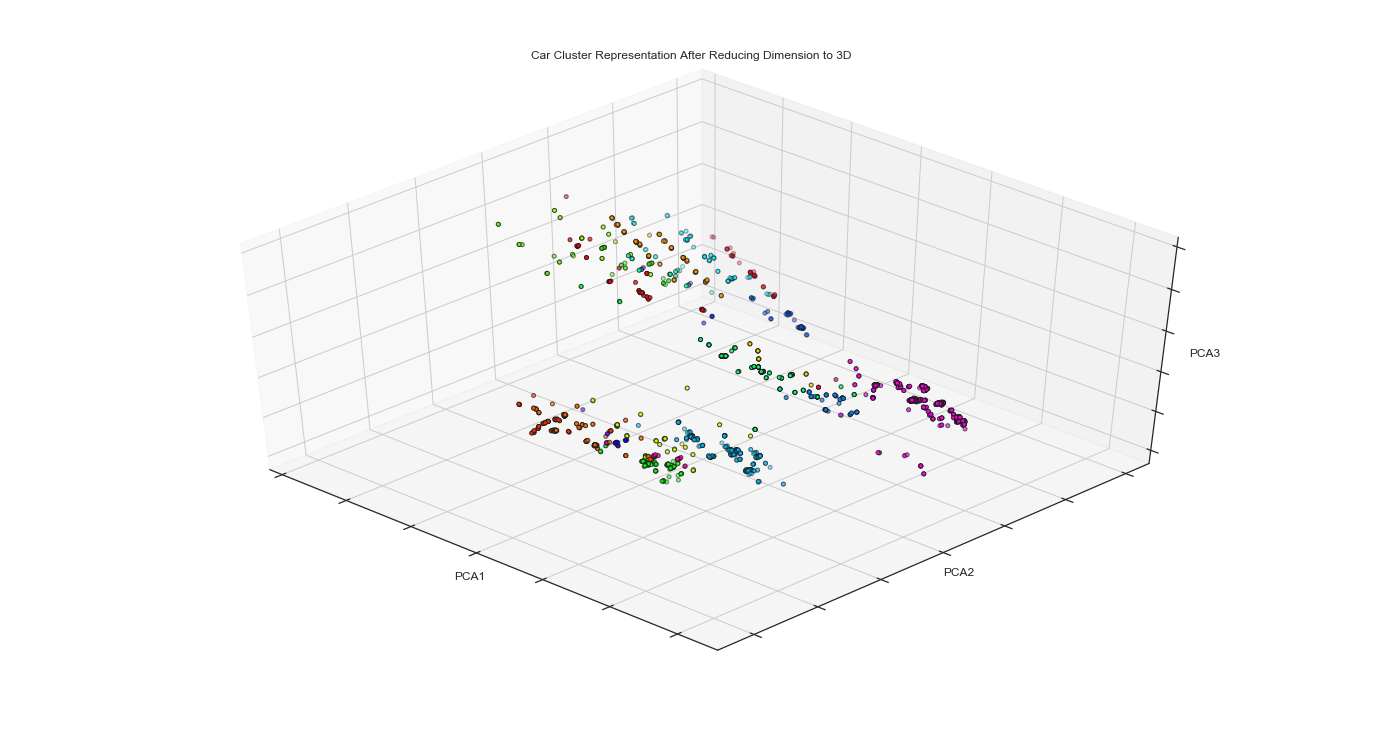

In [37]:
threed_figures(agg_clust_avg, df_gas_hac_avg)

### Linkage = Ward

In [38]:
df_gas_hac_ward = df_gas_mod.copy()

In [39]:
df_gas_hac_ward.iloc[:5,:-2];

In [40]:
agg_clust_ward = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward = agg_clust_ward.fit_predict(df_gas_hac_ward)
df_gas_hac_ward['labels'] = assigned_clust_ward

In [41]:
assigned_clust_ward

array([6, 6, 6, ..., 9, 9, 9])

In [42]:
hac_ward_ft_pca = pca.fit_transform((df_gas_hac_ward.iloc[:,:-1]))
df_gas_hac_ward['x']=hac_ward_ft_pca[:,0]
df_gas_hac_ward['y']=hac_ward_ft_pca[:,1]
df_gas_hac_ward['z']=hac_ward_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


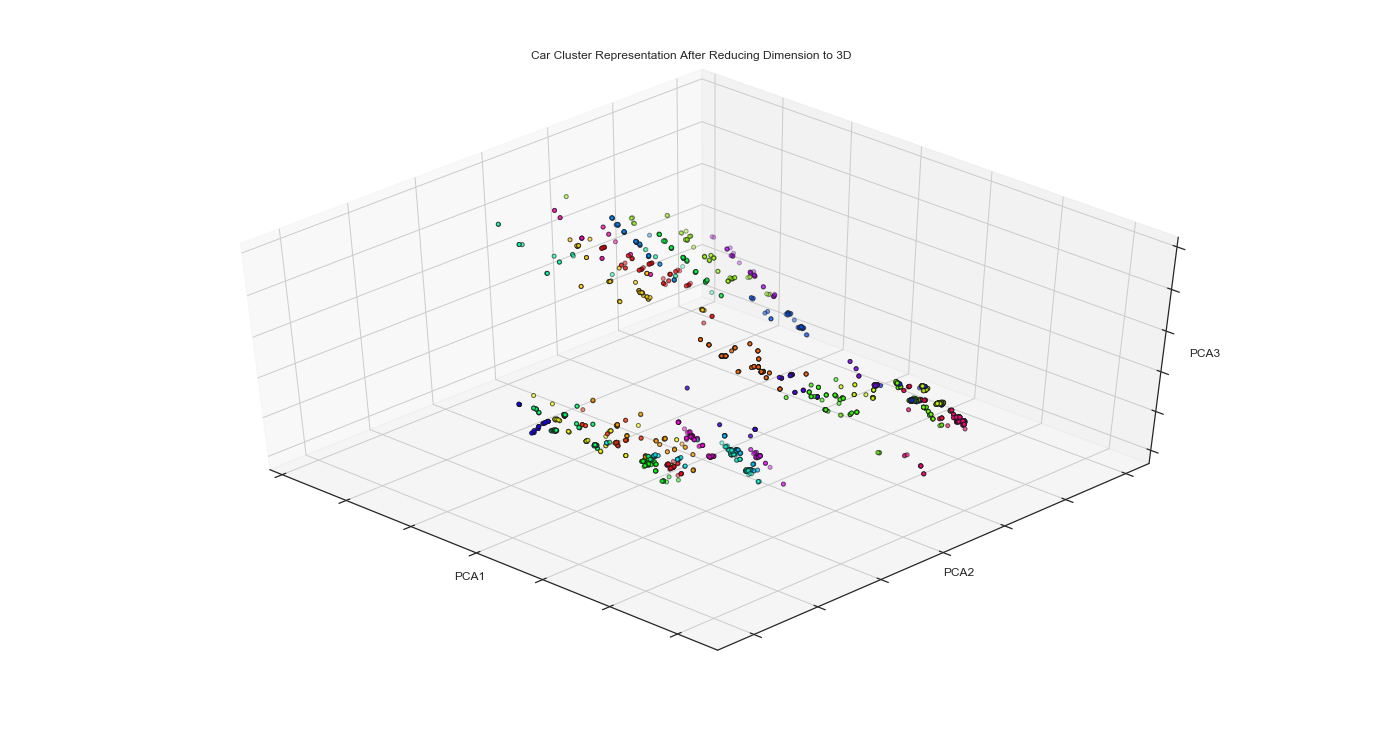

In [43]:
threed_figures(agg_clust_ward, df_gas_hac_ward)

### Dendograms, calinski_harabaz_score and silhouette_score

#### Dendograms

Text(0, 0.5, 'Cluster distance')

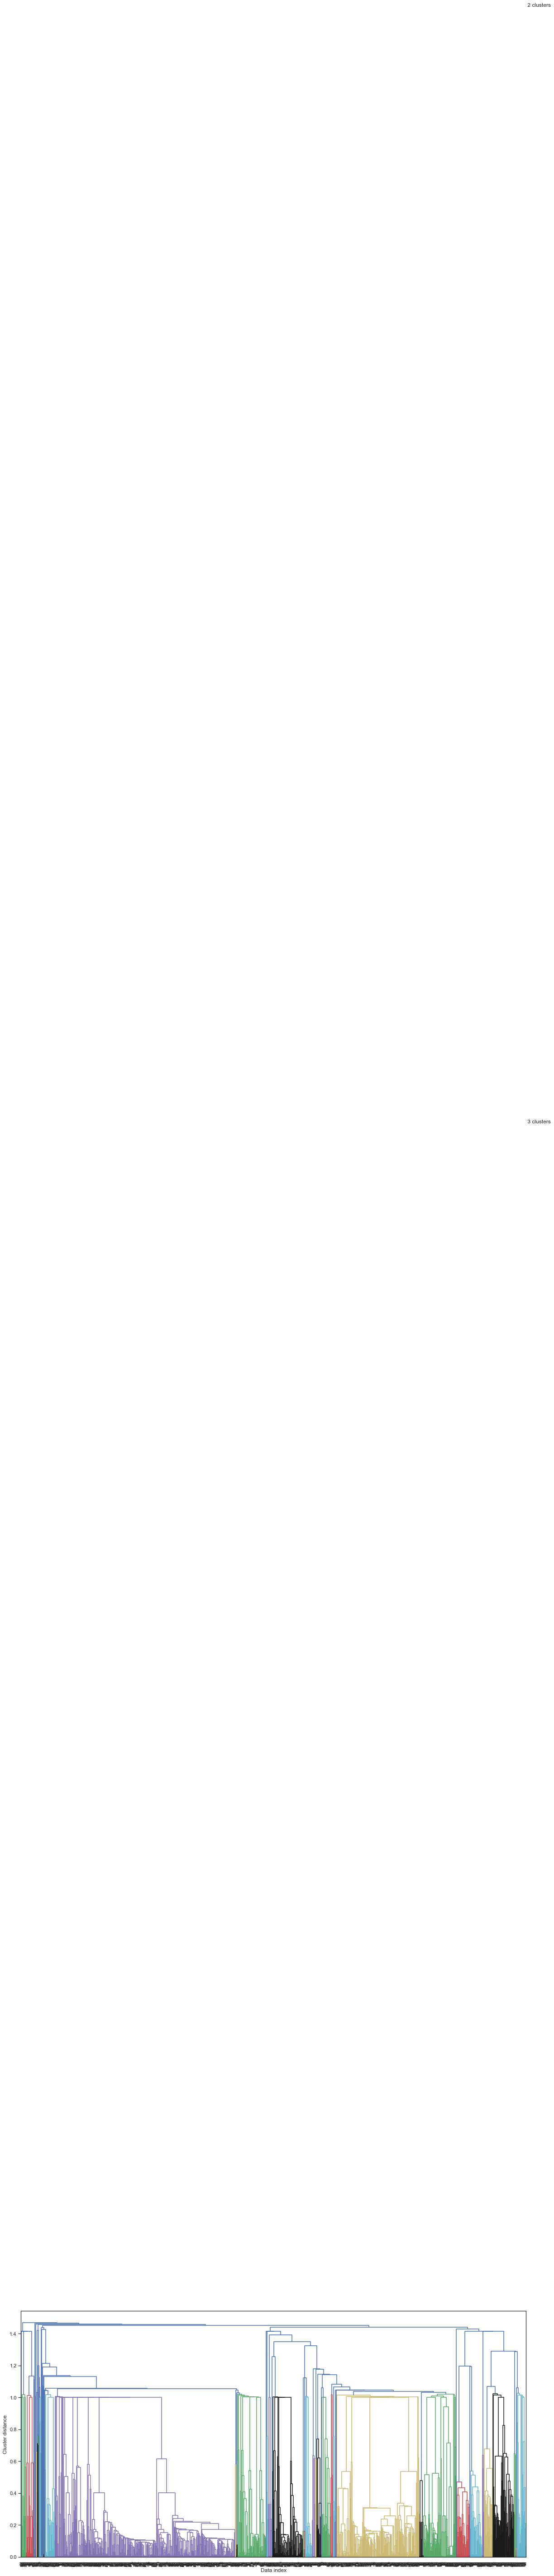

In [53]:
plt.figure(figsize=(20,10))
linkage_array = single(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

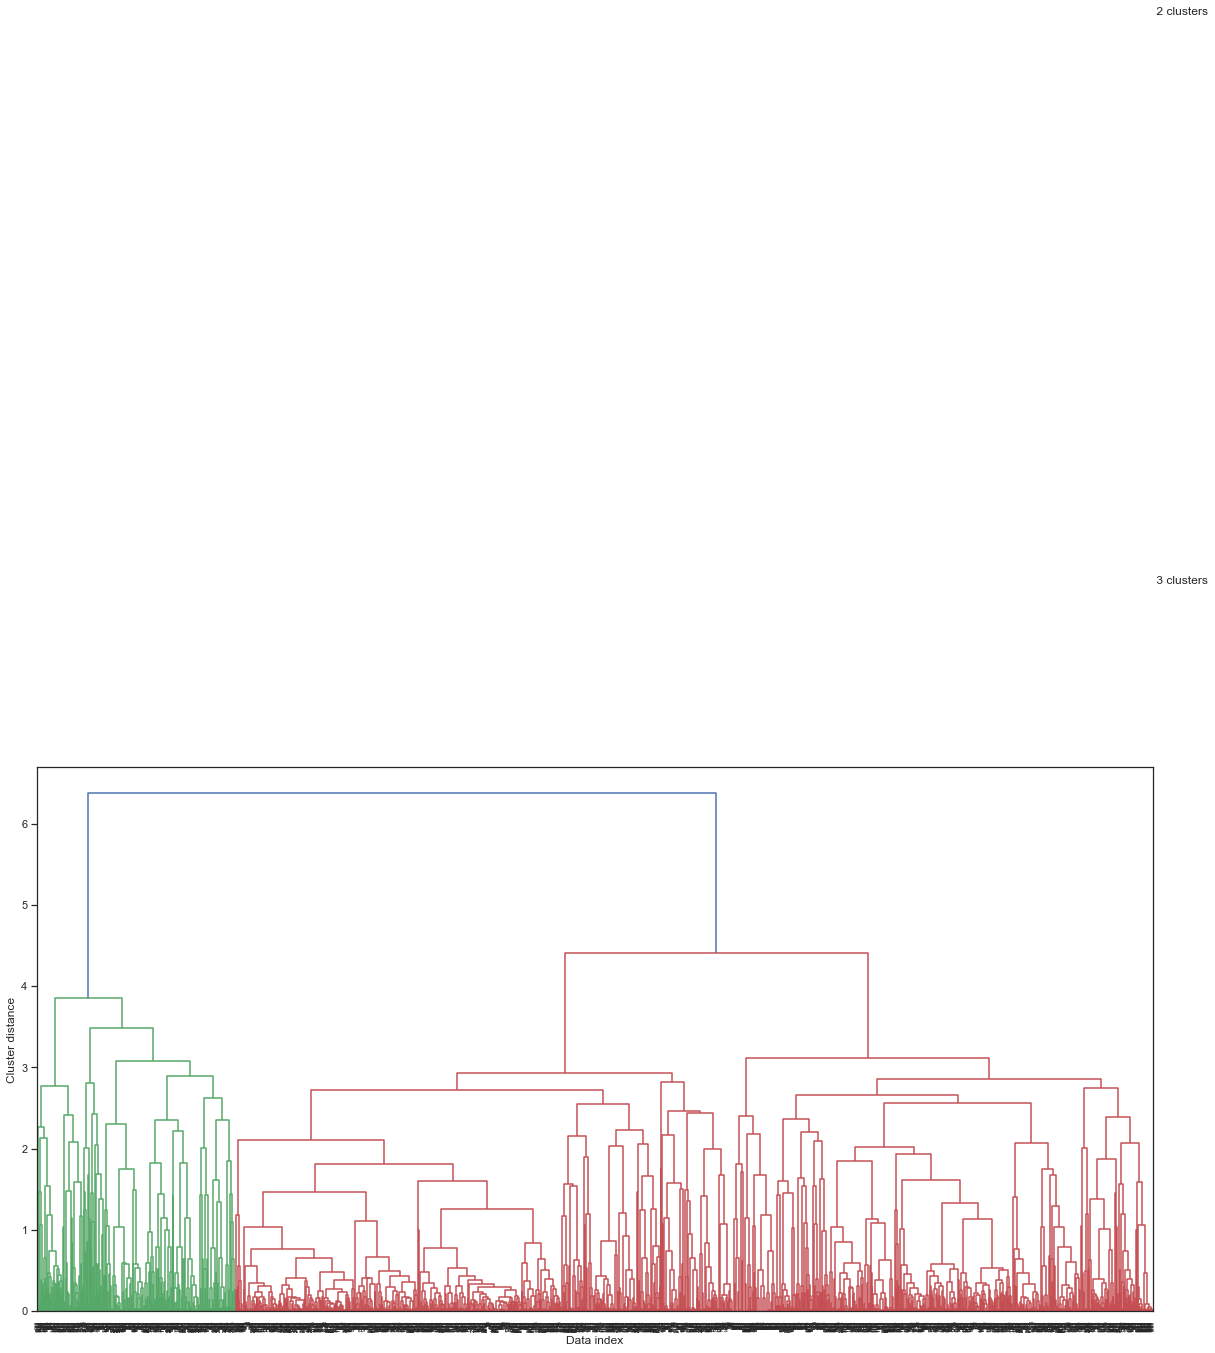

In [54]:
plt.figure(figsize=(20,10))
linkage_array = complete(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

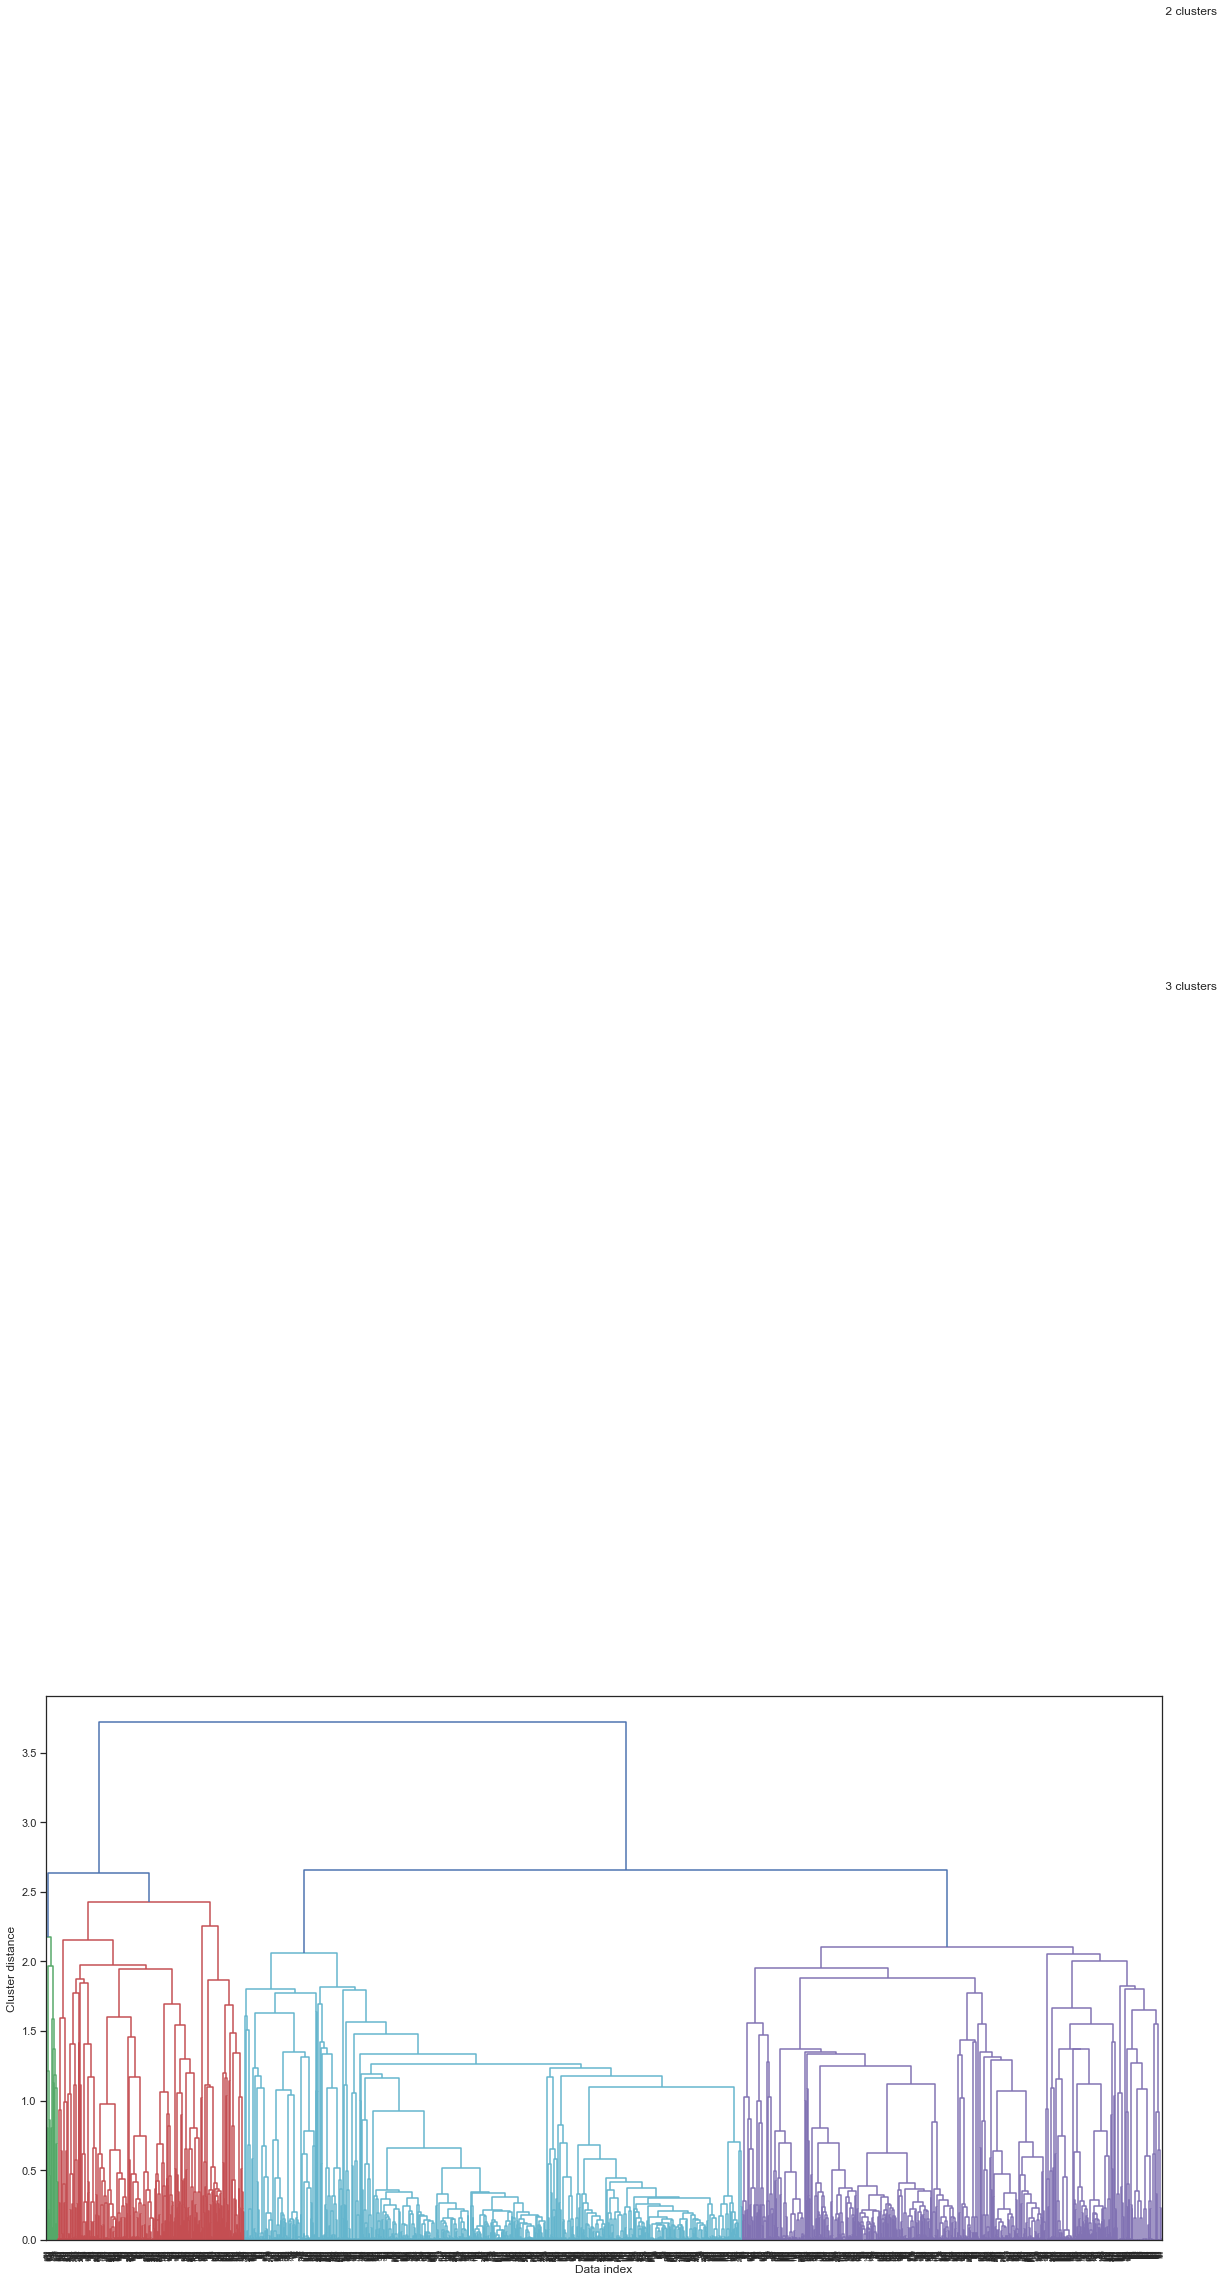

In [55]:
plt.figure(figsize=(20,10))
linkage_array = average(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

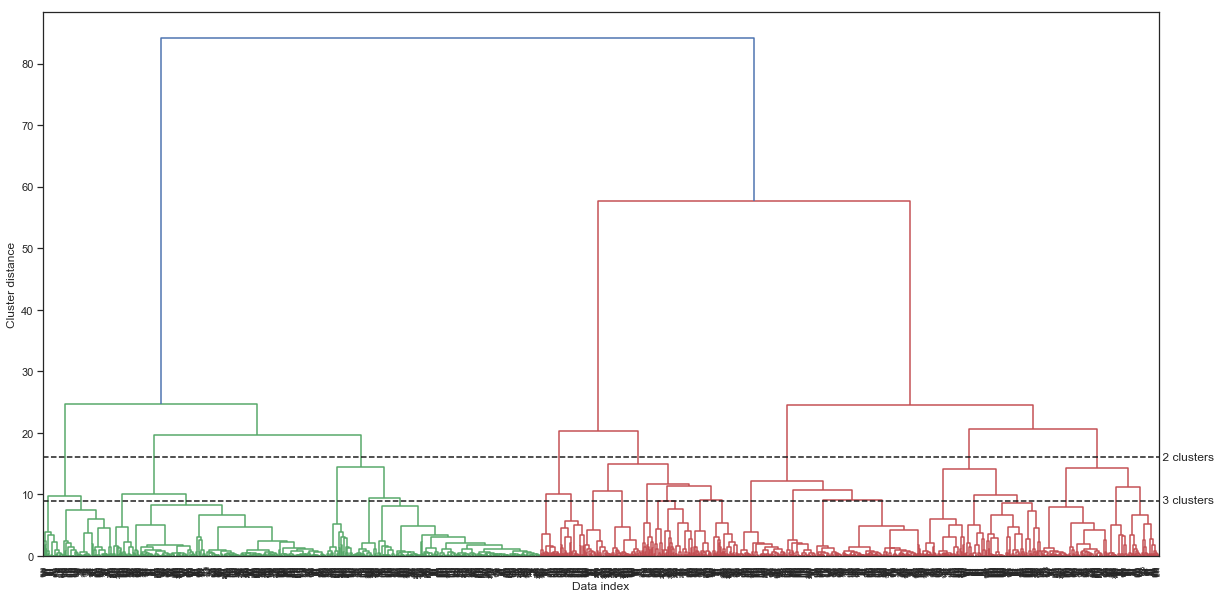

In [56]:

plt.figure(figsize=(20,10))
linkage_array = ward(df_gas_mod)

# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

In [44]:
as_kmeans = k_means.fit_predict(df_gas_mod)
as_single = agg_clust_single.fit_predict(df_gas_mod)
as_comp = agg_clust_complete.fit_predict(df_gas_mod)
as_avg = agg_clust_avg.fit_predict(df_gas_mod)
as_ward = agg_clust_ward.fit_predict(df_gas_mod)

In [45]:
labels_kmeans = labels
labels_single = agg_clust_single.labels_
labels_comp = agg_clust_complete.labels_
labels_avg = agg_clust_avg.labels_
labels_ward = agg_clust_ward.labels_

#### calinski_harabasz_score

In [46]:
metrics.calinski_harabasz_score(df_gas_mod, labels_kmeans)  

634.8090214933488

In [47]:
metrics.calinski_harabasz_score(df_gas_mod,labels_single)

197.3727850355849

In [48]:
metrics.calinski_harabasz_score(df_gas_mod,labels_ward)

636.5470408535263

In [49]:
metrics.calinski_harabasz_score(df_gas_mod,labels_avg)  

368.0248968953069

In [50]:
metrics.calinski_harabasz_score(df_gas_mod,labels_comp)  

415.18327319750193

#### silhouette_score

In [51]:
metrics.silhouette_score(df_gas_mod, labels_kmeans)

0.45717293788716035

In [52]:
metrics.silhouette_score(df_gas_mod, labels_single) 

0.23561343186388073

In [53]:
metrics.silhouette_score(df_gas_mod, labels_ward) 

0.4384215972530251

In [54]:
metrics.silhouette_score(df_gas_mod,labels_avg)  

0.3897969905342756

In [70]:
metrics.silhouette_score(df_gas_mod, labels_comp)  

0.3526313215100803

Recommender

In [56]:
df_gas_hac_ward['labels'];

In [57]:
df_for_brands_gas[df_gas_hac_ward['labels']==15][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

,brand,model,Torque,price,Passenger Capacity,trim
/cars/2019/ford/expedition/78148,Ford,Expedition,470,63015,8,Limited 4x2
/cars/2019/ford/expedition/78149,Ford,Expedition,470,66140,8,Limited 4x4
/cars/2019/ford/expedition/78150,Ford,Expedition,480,73365,8,Platinum 4x2
/cars/2019/ford/expedition/78151,Ford,Expedition,480,76515,8,Platinum 4x4
/cars/2019/ford/expedition/78152,Ford,Expedition,470,52130,8,XLT 4x2
/cars/2019/ford/expedition/78153,Ford,Expedition,470,55140,8,XLT 4x4
/cars/2019/ford/expedition-max/78142,Ford,Expedition,470,65705,8,Max Limited 4x2
/cars/2019/ford/expedition-max/78143,Ford,Expedition,470,68825,8,Max Limited 4x4
/cars/2019/ford/expedition-max/78144,Ford,Expedition,480,76060,8,Max Platinum 4x2
/cars/2019/ford/expedition-max/78145,Ford,Expedition,480,79200,8,Max Platinum 4x4


### PCA and AgglomerativeClustering

In [58]:
pca15 = PCA(n_components=15)
df_gas_transformed = pca15.fit_transform(df_gas_mod)

In [59]:
pca15.explained_variance_

array([2.18067477, 0.40634561, 0.29808329, 0.22366855, 0.1582216 ,
       0.1378909 , 0.10007716, 0.06925548, 0.05105436, 0.04180616,
       0.04120234, 0.03396822, 0.03146559, 0.02101526, 0.01905857])

In [60]:
pca15.explained_variance_ratio_

array([0.56176957, 0.1046798 , 0.07679005, 0.05761986, 0.0407599 ,
       0.03552245, 0.02578115, 0.01784109, 0.01315225, 0.0107698 ,
       0.01061425, 0.00875064, 0.00810594, 0.0054138 , 0.00490973])

In [61]:
np.cumsum(pca15.explained_variance_)

array([2.18067477, 2.58702038, 2.88510367, 3.10877222, 3.26699382,
       3.40488472, 3.50496187, 3.57421736, 3.62527171, 3.66707788,
       3.70828021, 3.74224843, 3.77371402, 3.79472928, 3.81378785])

In [62]:
np.cumsum(pca15.explained_variance_ratio_)

array([0.56176957, 0.66644937, 0.74323942, 0.80085929, 0.84161918,
       0.87714163, 0.90292278, 0.92076388, 0.93391613, 0.94468593,
       0.95530017, 0.96405082, 0.97215676, 0.97757056, 0.98248028])

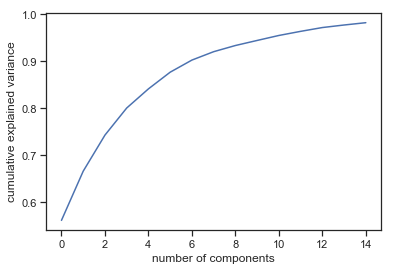

In [63]:
plt.plot(np.cumsum(pca15.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [64]:
df_gas_transformed = pd.DataFrame(df_gas_transformed, 
                                  index=df_gas_mod.index, 
                                  columns=list(map(lambda x: 'pca'+str(x), range(1,16))))
df_gas_transformed.shape

(2223, 15)

In [65]:
agg_clust_ward_pca = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_pca = agg_clust_ward_pca.fit_predict(pca15.fit_transform(df_gas_transformed))

In [66]:
df_gas_transformed['labels']=assigned_clust_ward_pca

In [67]:
df_gas_transformed.iloc[:,:-1];

In [68]:
metrics.silhouette_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

0.48536887400328516

In [69]:
metrics.calinski_harabasz_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

730.2451431576229

In [70]:
df_for_brands_gas[df_gas_transformed['labels']==2][['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

,brand,model,Torque,Passenger Capacity,price,trim
/cars/2018/alfa-romeo/4c/75370,Alfa,Romeo,258,2,55900,4C Coupe
/cars/2018/alfa-romeo/4c-spider/69017,Alfa,Romeo,258,2,65900,4C Spider Spider
/cars/2019/audi/a3/79106,Audi,A3,258,4,41700,Premium 45 TFSI quattro
/cars/2019/audi/a3/79104,Audi,A3,258,4,41700,Premium Plus 45 TFSI quattro
/cars/2019/audi/a3/79108,Audi,A3,258,4,41700,Prestige 45 TFSI quattro
/cars/2019/audi/a3-cabriolet/77679,Audi,A3,258,4,38900,Cabriolet 2.0 TFSI Premium Plus quattro AWD
/cars/2019/audi/a3-cabriolet/77680,Audi,A3,258,4,38900,Cabriolet 2.0 TFSI Premium quattro AWD
/cars/2019/audi/a3-cabriolet/77682,Audi,A3,258,4,38900,Cabriolet 2.0 TFSI Prestige quattro AWD
/cars/2019/audi/a5/77704,Audi,A5,273,4,38995,2.0 TFSI Premium
/cars/2019/audi/a5/77702,Audi,A5,273,4,38995,2.0 TFSI Premium Plus


In [71]:
transformed_plot=df_gas_transformed.copy()

In [72]:
pca_plot = pca.fit_transform((transformed_plot.iloc[:,:-1]))

In [73]:
transformed_plot['x']=pca_plot[:,0]

In [74]:
transformed_plot['y']=pca_plot[:,1]

In [75]:
transformed_plot['z']=pca_plot[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


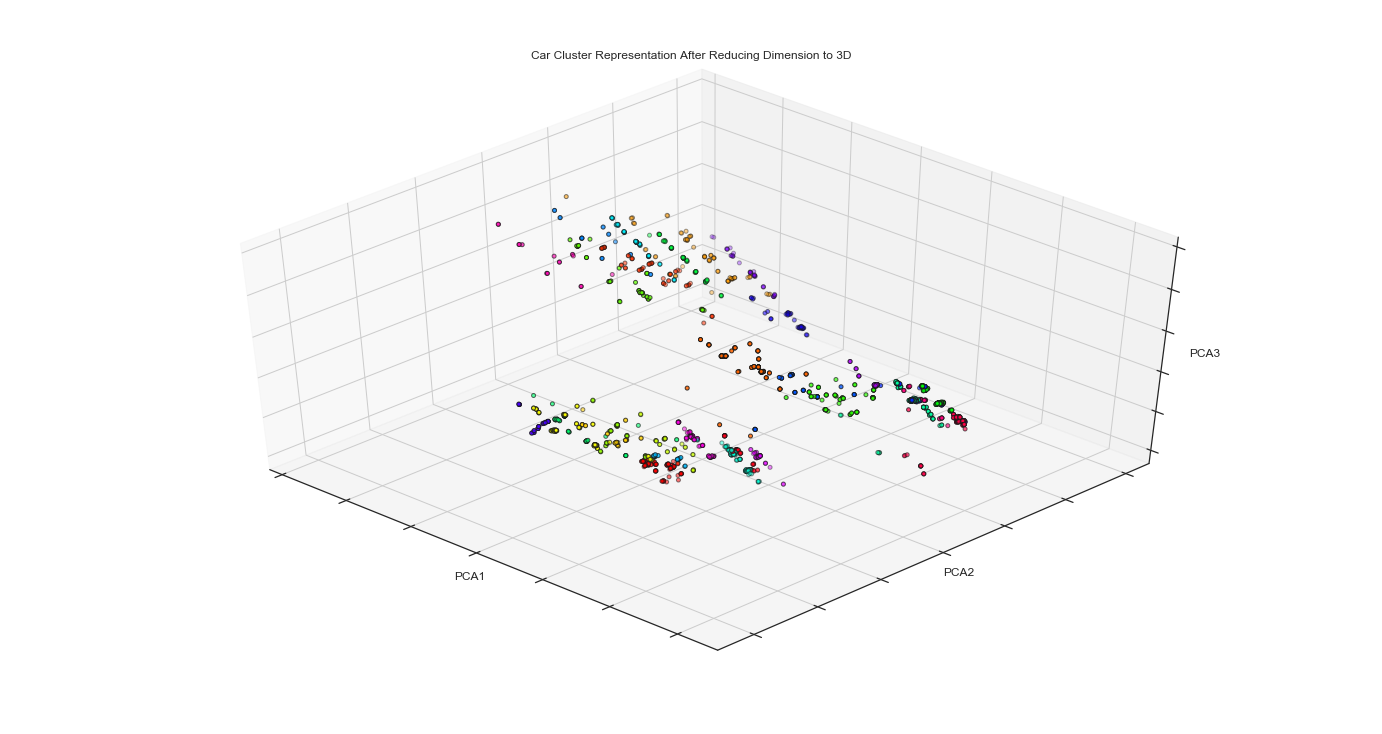

In [76]:
threed_figures(agg_clust_ward_pca, transformed_plot)

## Annoy

### TruncatedSVD

In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=11)

In [23]:
df_Annoy_svd = svd.fit_transform(df_gas_mod)

In [24]:
print(np.cumsum(svd.explained_variance_ratio_))
print(svd.singular_values_)

[0.40968461 0.61621028 0.69876376 0.75899439 0.81644876 0.85216069
 0.88574629 0.91152626 0.92917066 0.94224498 0.95301177]
[176.12175421  43.79096137  26.74633793  22.98941737  22.26836021
  17.55782886  17.08826438  14.91179647  12.33754308  10.61952387
   9.63676808]


In [26]:
df_Annoy_svd.shape

(2223, 11)

In [32]:
from annoy import AnnoyIndex
import random

f = df_Annoy_svd.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_svd.shape[0]):
    v = df_Annoy_svd[i]
    t.add_item(i, v)

t.build(15)
t.save('test.ann')

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """


True

In [37]:
df_gas_mod

,price,base_engine_size,fuel_tank_capacity,epa_mileage_combined,Horsepower,Torque,third_row_seating,first_row_seating,rear_row_seating,curb_weight,...,Cylinders_4.0,Cylinders_5.0,Cylinders_6.0,Cylinders_8.0,Cylinders_10.0,Cylinders_12.0,engine_type_2,drive_type_1,drive_type_2,drive_type_3
/cars/2019/acura/ilx/79088,0.028002,2.4,0.151220,0.168675,0.171071,0.123113,0.000000,0.156915,0.189442,0.156797,...,1,0,0,0,0,0,0,0,1,0
/cars/2019/acura/ilx/79090,0.031648,2.4,0.151220,0.168675,0.171071,0.123113,0.000000,0.156915,0.189442,0.160939,...,1,0,0,0,0,0,0,0,1,0
/cars/2019/acura/ilx/79089,0.035815,2.4,0.151220,0.168675,0.171071,0.123113,0.000000,0.156915,0.189442,0.164314,...,1,0,0,0,0,0,0,0,1,0
/cars/2019/acura/ilx/79092,0.035607,2.4,0.151220,0.168675,0.171071,0.123113,0.000000,0.156915,0.189442,0.161246,...,1,0,0,0,0,0,0,0,1,0
/cars/2019/acura/ilx/79091,0.039774,2.4,0.151220,0.168675,0.171071,0.123113,0.000000,0.156915,0.189442,0.164928,...,1,0,0,0,0,0,0,0,1,0
/cars/2019/acura/mdx/77624,0.066338,3.5,0.304878,0.108434,0.294854,0.224158,0.351861,0.250347,0.381952,0.300552,...,0,0,1,0,0,0,0,0,1,0
/cars/2019/acura/mdx/77621,0.090819,3.5,0.304878,0.108434,0.294854,0.224158,0.351861,0.250347,0.381952,0.309451,...,0,0,1,0,0,0,0,0,1,0
/cars/2019/acura/mdx/77620,0.094986,3.5,0.304878,0.108434,0.294854,0.224158,0.351861,0.250347,0.381952,0.316508,...,0,0,1,0,0,0,0,0,1,0
/cars/2019/acura/mdx/77623,0.076756,3.5,0.304878,0.108434,0.294854,0.224158,0.351861,0.250347,0.381952,0.303928,...,0,0,1,0,0,0,0,0,1,0
/cars/2019/acura/mdx/77622,0.080923,3.5,0.304878,0.108434,0.294854,0.224158,0.351861,0.250347,0.381952,0.304388,...,0,0,1,0,0,0,0,0,1,0


In [33]:
df_gas_mod.index[100]

'/cars/2019/audi/a5/79114'

In [34]:
def nearest_car_Annoy(df, car_idx, index, n, print_output=True):
    nn = index.get_nns_by_item(car_idx, n)
    if print_output == True:
        print('Closest to %s : \n' % df.index[car_idx])
    cars = [df.index[i] for i in nn]
    if print_output == True:
        return df_for_brands_gas.loc[cars, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [35]:
def index_finder(string1,string2):
    index_list = []
    for i in df_for_brands_gas.index:
        if re.findall(str(string1).lower()+'\/'+str(string2).lower(), i):
            index_list.append(i)
    return df_for_brands_gas.loc[index_list, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [36]:
nearest_car_Annoy(df_gas_mod, 100, t, n=20)

Closest to /cars/2019/audi/a5/79114 : 



,brand,model,Torque,Passenger Capacity,price,trim
/cars/2019/audi/a5/79114,Audi,A5,369,4,52400,Premium 3.0 TFSI quattro
/cars/2019/audi/a5/79113,Audi,A5,369,4,65100,Premium Plus 3.0 TFSI quattro
/cars/2019/audi/a5/79115,Audi,A5,369,4,65100,Prestige 3.0 TFSI quattro
/cars/2019/mercedes-benz/c-class/78753,Mercedes-Benz,C,384,4,63650,Class AMG C 43 4MATIC Cabriolet
/cars/2019/audi/s5-cabriolet/77732,Audi,S5,369,4,35100,Cabriolet 3.0 TFSI Premium Plus
/cars/2019/audi/s5-cabriolet/77733,Audi,S5,369,4,35100,Cabriolet 3.0 TFSI Prestige
/cars/2019/mercedes-benz/c-class/78754,Mercedes-Benz,C,384,4,57450,Class AMG C 43 4MATIC Coupe
/cars/2017/infiniti/q60-coupe/47451,Infiniti,Q60,350,4,48700,Coupe Red Sport 400 - Coupe 3.0L V6 Twin-turbo...
/cars/2019/audi/s5-coupe/77735,Audi,S5,369,4,35100,Coupe 3.0 TFSI Premium
/cars/2019/audi/s5-coupe/77734,Audi,S5,369,4,35100,Coupe 3.0 TFSI Premium Plus


In [85]:
nearest_car_Annoy(df_gas_mod, 1295, t, n=20)

Closest to /cars/2019/lexus/ls/79559 : 



,brand,model,Torque,Passenger Capacity,price,trim
/cars/2019/lexus/ls/79560,Lexus,LS,442,5,84670,LS 500 F SPORT AWD
/cars/2019/lexus/ls/79559,Lexus,LS,442,5,78670,LS 500 AWD
/cars/2019/ford/taurus/78231,Ford,Taurus,350,5,42975,SHO AWD
/cars/2019/cadillac/ct6/77856,Cadillac,CT6,400,5,78195,4-Door Sedan 3.6L Luxury AWD
/cars/2019/ford/taurus/78226,Ford,Taurus,254,5,39160,Limited AWD
/cars/2019/ford/taurus/78229,Ford,Taurus,254,5,32080,SEL AWD
/cars/2019/cadillac/xt5/77890,Cadillac,XT5,271,5,65895,AWD 4-Door Platinum
/cars/2019/cadillac/xt5/77891,Cadillac,XT5,271,5,56695,AWD 4-Door Premium Luxury
/cars/2019/cadillac/xt5/77889,Cadillac,XT5,271,5,50995,AWD 4-Door Luxury
/cars/2019/cadillac/xt5/77892,Cadillac,XT5,271,5,44695,AWD 4-Door


In [87]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(df_gas_mod)

(2223, 3)

In [107]:
df_plot = pd.DataFrame(X_embedded, index=transformed_plot.index, columns = ['x','y','z'])

In [159]:
agg_clust_ward_tsne = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_tsne = agg_clust_ward_tsne.fit_predict(df_plot)

In [160]:
df_plot['labels']=assigned_clust_ward_tsne

In [161]:
import plotly.express as px
fig = px.scatter_3d(df_plot, x='x', y='y', z='z', color='labels')
fig.show()

### All Features

In [ ]:
df_gas_mod.shape

In [ ]:
from annoy import AnnoyIndex
import random

f = df_gas_mod.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_gas_mod.shape[0]):
    v = df_gas_mod.iloc[i,:]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

In [162]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

Closest to /cars/2019/audi/a4-allroad/77690 : 



,brand,model,Torque,Passenger Capacity,price,trim
/cars/2019/audi/a4-allroad/77690,Audi,A4,273,5,38995,allroad 2.0 TFSI Premium
/cars/2019/audi/a4-allroad/77689,Audi,A4,273,5,38995,allroad 2.0 TFSI Premium Plus
/cars/2019/audi/a4-allroad/77691,Audi,A4,273,5,38995,allroad 2.0 TFSI Prestige
/cars/2019/genesis/g70/79255,Genesis,G70,260,5,36900,2.0T Advanced AWD
/cars/2019/audi/a5-sportback/77699,Audi,A5,273,5,38995,Sportback 2.0 TFSI Premium
/cars/2019/audi/a5-sportback/77698,Audi,A5,273,5,38995,Sportback 2.0 TFSI Premium Plus
/cars/2019/audi/a5-sportback/77700,Audi,A5,273,5,38995,Sportback 2.0 TFSI Prestige
/cars/2019/bmw/3-series/77752,BMW,3-Series,295,5,42250,330i xDrive Sports Wagon
/cars/2019/kia/stinger/79516,Kia,Stinger,260,5,41390,Premium AWD
/cars/2019/kia/stinger/79508,Kia,Stinger,260,5,35190,Base AWD


### All Features

In [ ]:
df_Annoy_pca = pca15.fit_transform(df_gas_mod)

In [ ]:
from annoy import AnnoyIndex
import random

f = df_Annoy_pca.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_pca.shape[0]):
    v = df_Annoy_pca[i]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

In [163]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

Closest to /cars/2019/audi/a4-allroad/77690 : 



,brand,model,Torque,Passenger Capacity,price,trim
/cars/2019/audi/a4-allroad/77690,Audi,A4,273,5,38995,allroad 2.0 TFSI Premium
/cars/2019/audi/a4-allroad/77689,Audi,A4,273,5,38995,allroad 2.0 TFSI Premium Plus
/cars/2019/audi/a4-allroad/77691,Audi,A4,273,5,38995,allroad 2.0 TFSI Prestige
/cars/2019/genesis/g70/79255,Genesis,G70,260,5,36900,2.0T Advanced AWD
/cars/2019/audi/a5-sportback/77699,Audi,A5,273,5,38995,Sportback 2.0 TFSI Premium
/cars/2019/audi/a5-sportback/77698,Audi,A5,273,5,38995,Sportback 2.0 TFSI Premium Plus
/cars/2019/audi/a5-sportback/77700,Audi,A5,273,5,38995,Sportback 2.0 TFSI Prestige
/cars/2019/bmw/3-series/77752,BMW,3-Series,295,5,42250,330i xDrive Sports Wagon
/cars/2019/kia/stinger/79516,Kia,Stinger,260,5,41390,Premium AWD
/cars/2019/kia/stinger/79508,Kia,Stinger,260,5,35190,Base AWD


# Function tobe Dashed

In [1]:
val1 = input("Enter your favourite car brand: ") 
val2 = input("And model: ")
index_finder(val1,val2)

Enter your favourite car brand: audi
And model: a5


NameError: name 'index_finder' is not defined

In [230]:
val3 = input("Enter desired trim index: ") 
val3_iloc = list(df_gas_mod.index).index(str(val3))
nearest_car_Annoy(df_gas_mod, val3_iloc, t, n=20)

Enter desired trim index: /cars/2019/bmw/3-series/77753
Closest to /cars/2019/bmw/3-series/77753 : 



,brand,model,Torque,Passenger Capacity,price,trim
/cars/2019/bmw/3-series/77753,BMW,3-Series,330,5,51250,340i xDrive Gran Turismo
/cars/2019/bmw/5-series/77772,BMW,5-Series,332,5,61250,540i xDrive Sedan
/cars/2017/infiniti/q50/47442,Infiniti,Q50,295,5,26995,Sport - Sedan 3.0L V6 Twin-turbo AWD auto
/cars/2017/infiniti/q50/47440,Infiniti,Q50,295,5,26995,3.0t Premium - Sedan 3.0L V6 Twin-turbo AWD auto
/cars/2017/infiniti/q50/47434,Infiniti,Q50,295,5,26995,3.0t Signature Edition - Sedan 3.0L V6 Twin-tu...
/cars/2019/audi/a6/77707,Audi,A6,369,5,50200,3.0 TFSI Premium Plus quattro AWD
/cars/2019/audi/a6/77708,Audi,A6,369,5,50200,3.0 TFSI Premium quattro AWD
/cars/2019/audi/a6/77709,Audi,A6,369,5,50200,3.0 TFSI Prestige quattro AWD
/cars/2019/bmw/6-series/77775,BMW,6-Series,330,5,84500,640i xDrive Gran Coupe
/cars/2019/audi/q8/77724,Audi,Q8,369,5,52400,3.0 TFSI Premium
